# Pattern Mining

## Heart Failure Prediction Dataset

### Imports

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
import mlxtend.frequent_patterns as pm
from mlxtend.preprocessing import TransactionEncoder

### Discretize Numeric Variables

In [120]:
data: pd.DataFrame = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')

numeric_vars = data.select_dtypes(include='number').columns

for n in range(len(numeric_vars)):
    num_unique = len(list(set(data[numeric_vars[n]].values)))

    data[numeric_vars[n]] = pd.cut(data[numeric_vars[n]], num_unique, labels = list(range(0, num_unique)))

data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,29,0,14,0,1,1,51,6,13,1,0,0,1
1,12,0,207,0,6,0,50,2,17,1,0,1,1
2,21,0,3,0,1,0,29,3,12,1,1,1,1
3,8,1,2,0,1,0,39,6,18,1,0,1,1
4,21,1,3,1,1,0,64,9,2,0,0,2,1


### Patterns

Processing 14 combinations | Sampling itemset size 14320
19791 patterns


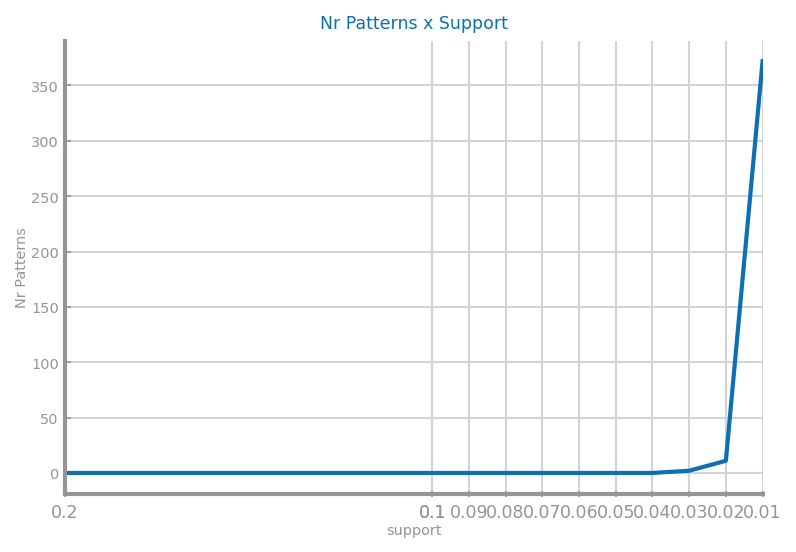

In [121]:
MIN_SUP: float = 0.001
var_min_sup =[0.2, 0.1] + [i*MIN_SUP for i  in range(100, 0, -10)]


te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
data = pd.DataFrame(te_ary, columns=te.columns_)

patterns: pd.DataFrame = pm.apriori(data, min_support=MIN_SUP, use_colnames=True, verbose=True)
print(len(patterns),'patterns')
nr_patterns = []
for sup in var_min_sup:
    pat = patterns[patterns['support']>=sup]
    nr_patterns.append(len(pat))

plt.figure(figsize=(6, 4))
ds.plot_line(var_min_sup, nr_patterns, title='Nr Patterns x Support', xlabel='support', ylabel='Nr Patterns')
plt.show()

### Association Rules

In [122]:
def plot_top_rules(rules: pd.DataFrame, metric: str, per_metric: str) -> None:
    _, ax = plt.subplots(figsize=(6, 3))
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(f'TOP 10 per Min {per_metric} - {metric}', fontweight="bold")
    text = ''
    cols = ['antecedents', 'consequents']
    rules[cols] = rules[cols].applymap(lambda x: tuple(x))
    for i in range(len(rules)):
        rule = rules.iloc[i]
        text += f"{rule['antecedents']} ==> {rule['consequents']}"
        text += f"(s: {rule['support']:.2f}, c: {rule['confidence']:.2f}, lift: {rule['lift']:.2f})\n"
    ax.text(0, 0, text)
    plt.show()

def analyse_per_metric(rules: pd.DataFrame, metric: str, metric_values: list) -> list:
    print(f'Analyse per {metric}...')
    conf = {'avg': [], 'top25%': [], 'top10': []}
    lift = {'avg': [], 'top25%': [], 'top10': []}
    top_conf = []
    top_lift = []
    nr_rules = []
    for m in metric_values:
        rs = rules[rules[metric] >= m]
        nr_rules.append(len(rs))
        conf['avg'].append(rs['confidence'].mean(axis=0))
        lift['avg'].append(rs['lift'].mean(axis=0))

        top_conf = rs.nlargest(int(0.25*len(rs)), 'confidence')
        conf['top25%'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(int(0.25*len(rs)), 'lift')
        lift['top25%'].append(top_lift['lift'].mean(axis=0))

        top_conf = rs.nlargest(10, 'confidence')
        conf['top10'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(10, 'lift')
        lift['top10'].append(top_lift['lift'].mean(axis=0))

    _, axs = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)
    ds.multiple_line_chart(metric_values, conf, ax=axs[0, 0], title=f'Avg Confidence x {metric}',
                           xlabel=metric, ylabel='Avg confidence')
    ds.multiple_line_chart(metric_values, lift, ax=axs[0, 1], title=f'Avg Lift x {metric}',
                           xlabel=metric, ylabel='Avg lift')
    plt.show()

    plot_top_rules(top_conf, 'confidence', metric)
    plot_top_rules(top_lift, 'lift', metric)

    return nr_rules

### Quality Evaluation per Confidence

In [123]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='confidence', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 2976813 rules


Analyse per confidence...


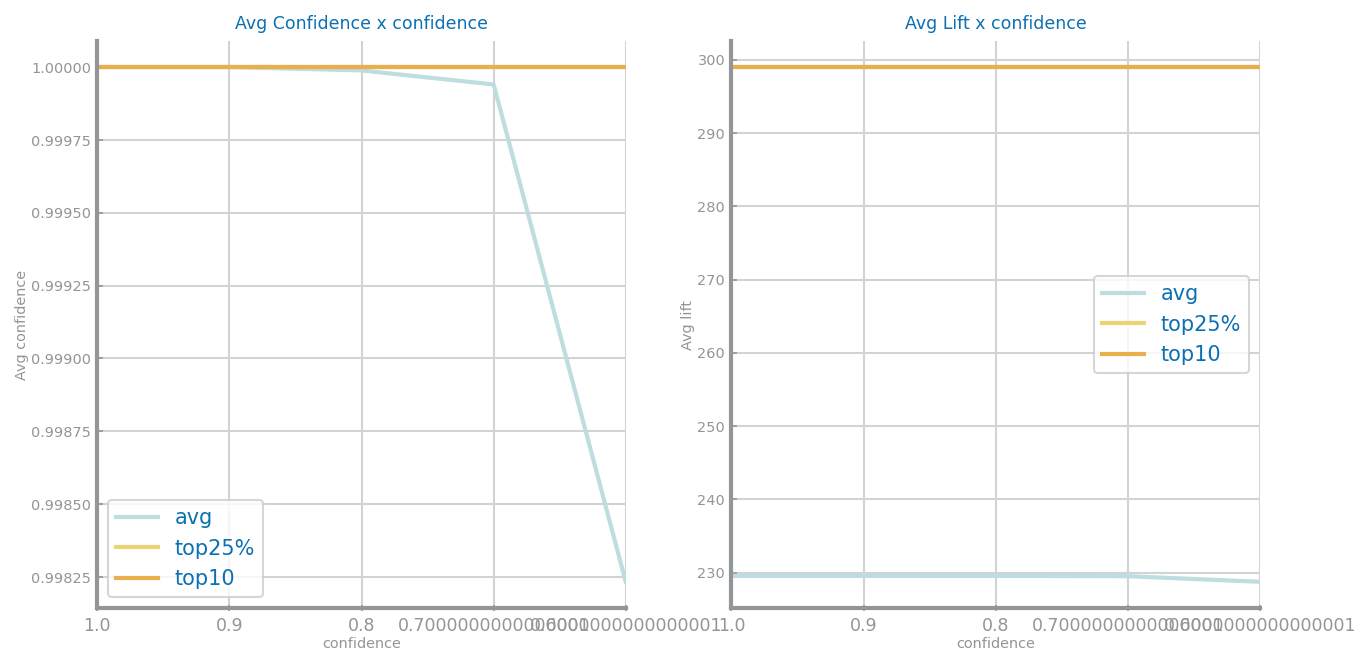

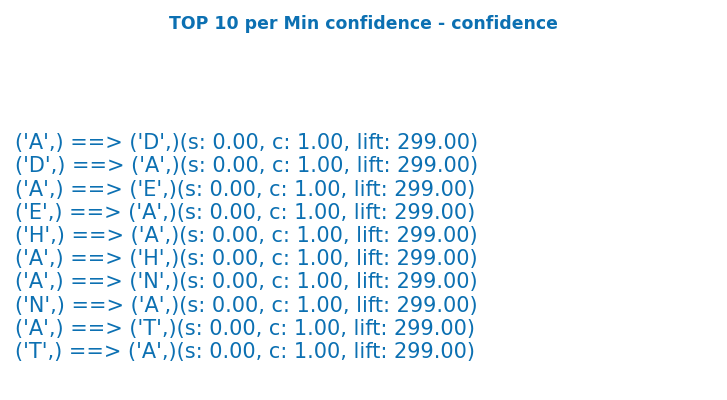

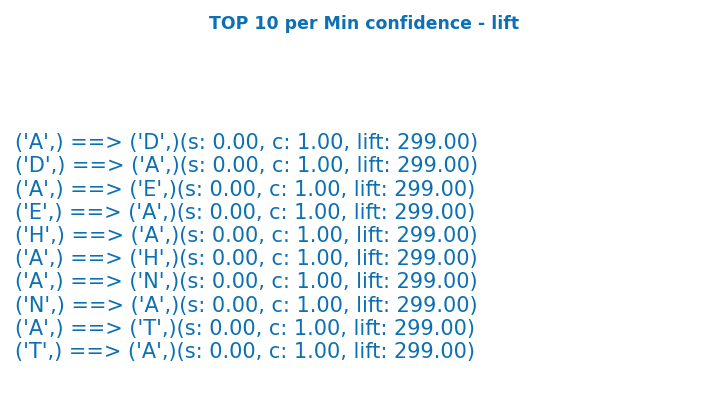

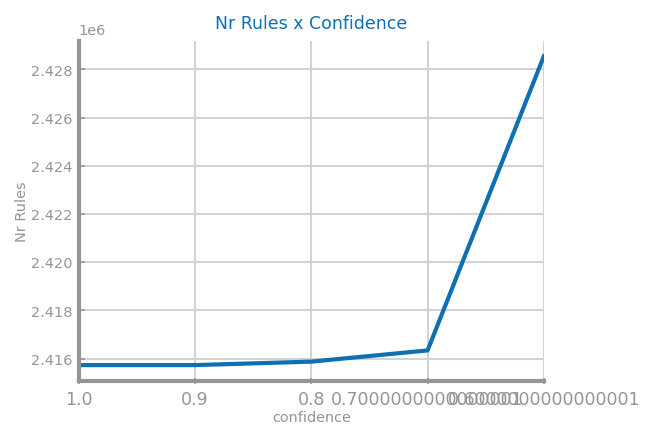

In [124]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'confidence', var_min_conf)
ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Confidence', xlabel='confidence', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Support

In [126]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='support', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [111]:
#var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
#nr_rules_cf = analyse_per_metric(rules, 'support', var_min_conf)
#ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Support', xlabel='support', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Lift

In [127]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='lift', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 3479156 rules


Analyse per lift...


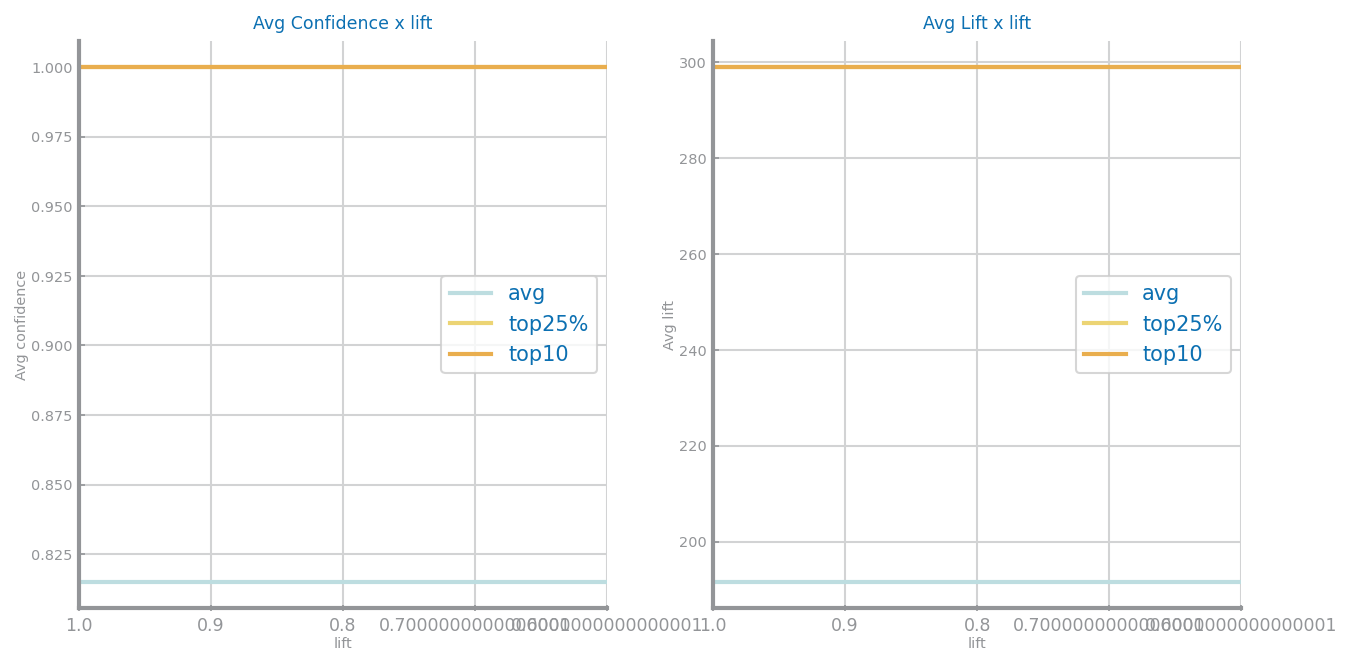

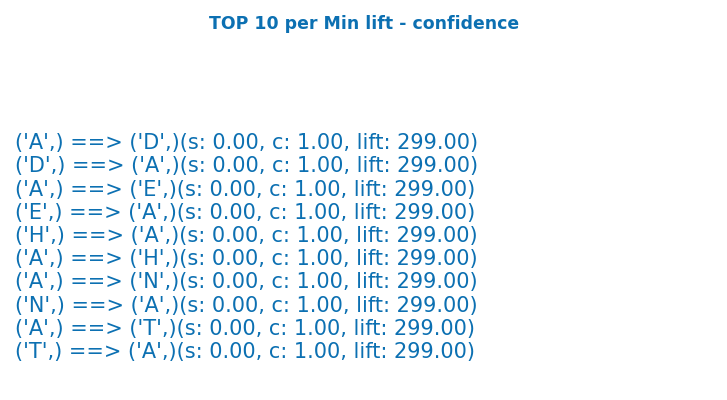

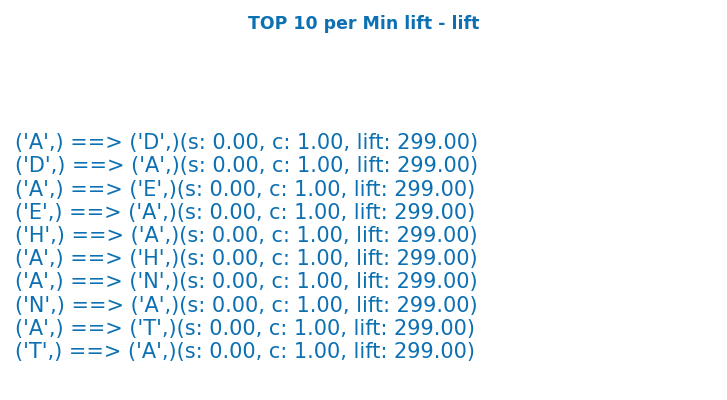

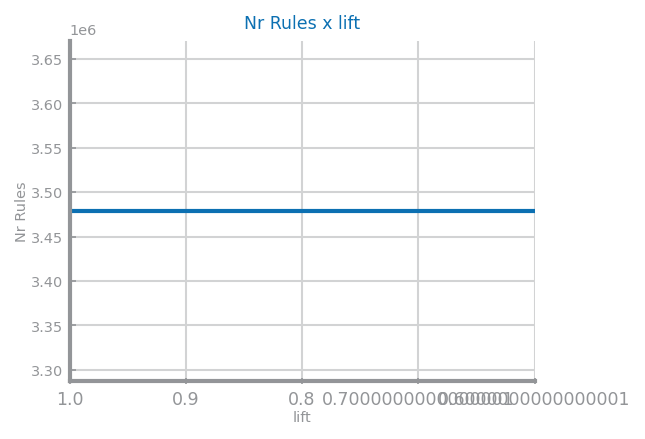

In [128]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'lift', var_min_conf)
ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x lift', xlabel='lift', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Leverage

In [129]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='leverage', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [115]:
#var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
#nr_rules_cf = analyse_per_metric(rules, 'leverage', var_min_conf)
#ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x leverage', xlabel='leverage', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Conviction

In [130]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='conviction', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 3479156 rules


Analyse per conviction...


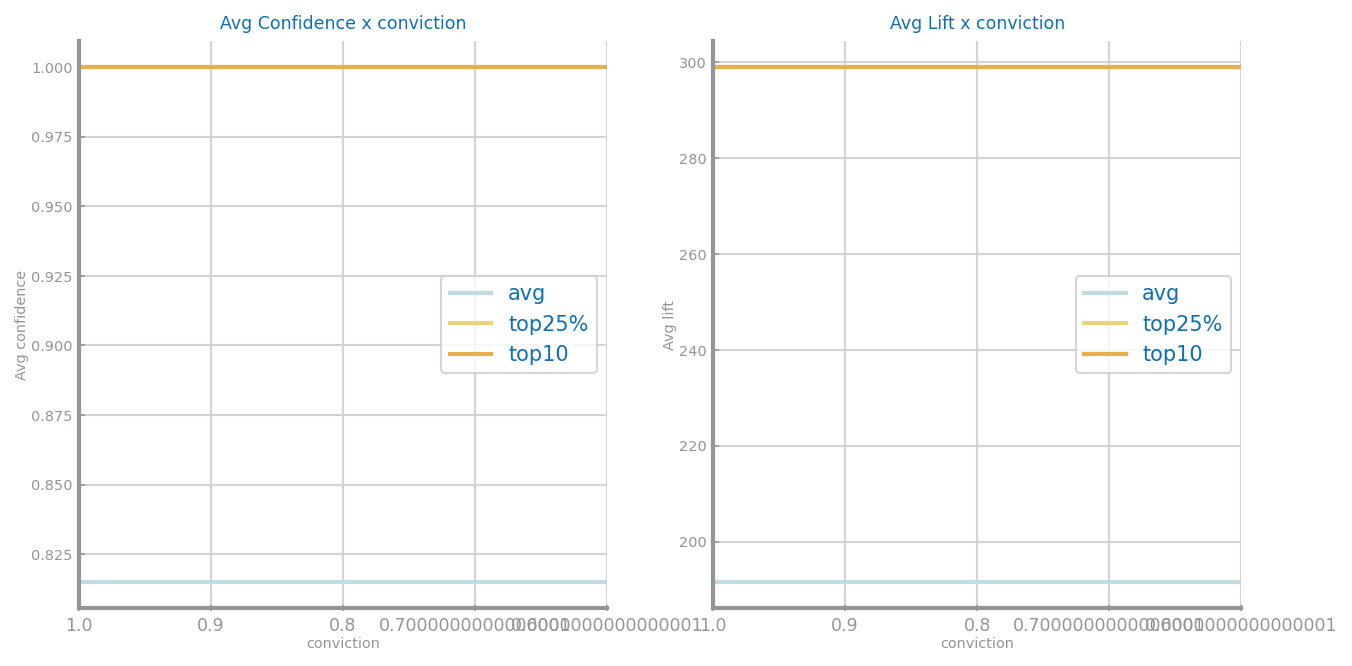

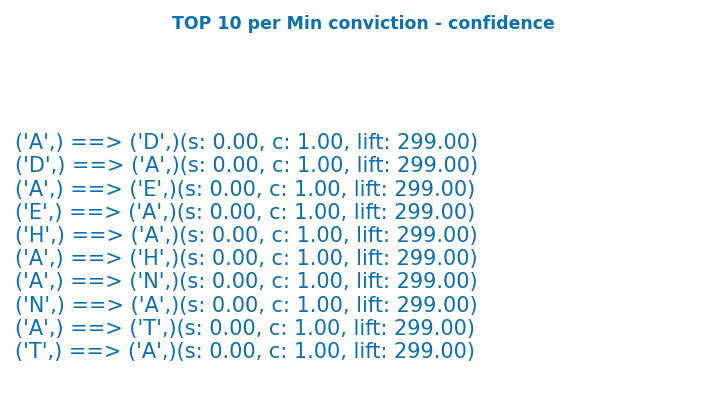

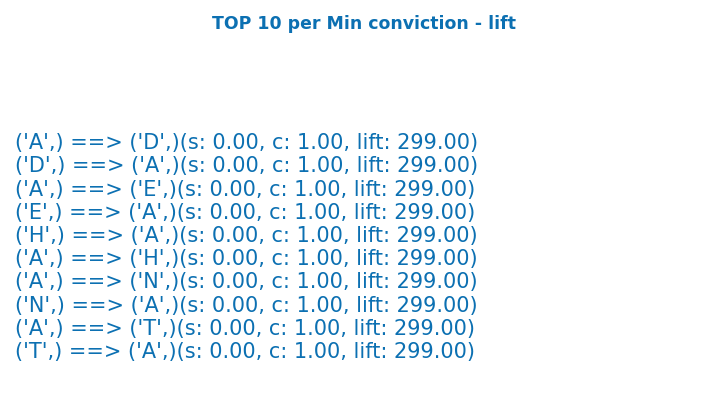

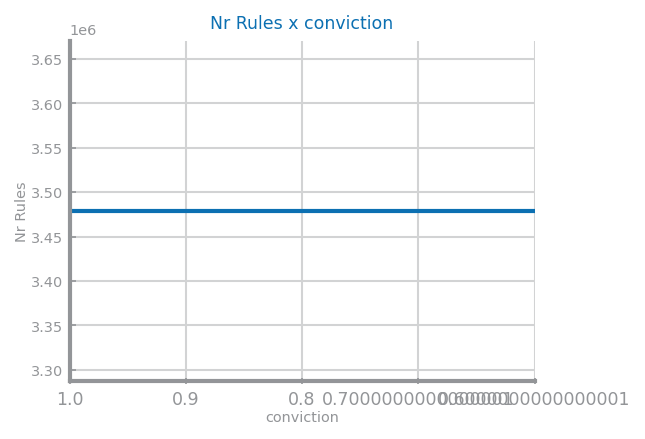

In [131]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'conviction', var_min_conf)
ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x conviction', xlabel='conviction', ylabel='Nr Rules', percentage=False)

<br/>
<br/>
<br/>
<br/>
<br/>

## QSAR Oral Toxicity

### Imports

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
import mlxtend.frequent_patterns as pm
from mlxtend.preprocessing import TransactionEncoder

### Load Data

In [133]:
data: pd.DataFrame = pd.read_csv('../datasets/qsar_oral_toxicity.csv', sep=';', header=None)   

data.columns = [str(i) for i in range(0, 1025)]

data.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,negative
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,negative
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative


### Patterns

Processing 360 combinations | Sampling itemset size 3
56 patterns


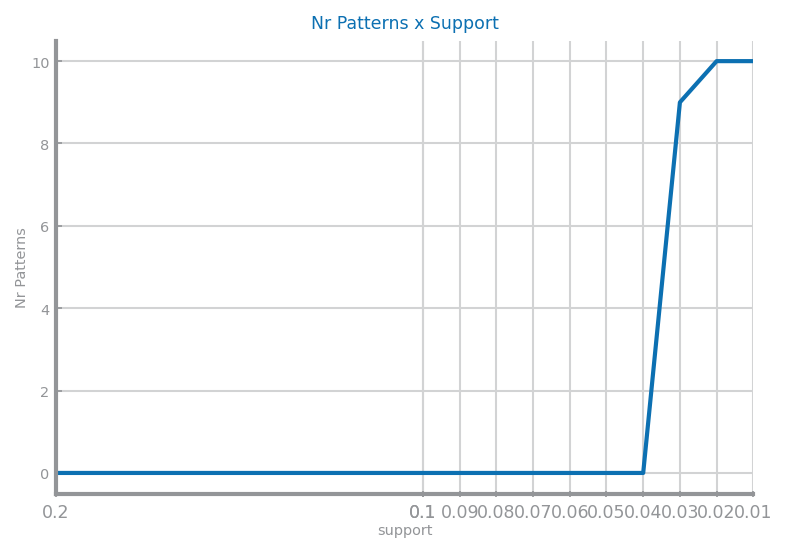

In [134]:
MIN_SUP: float = 0.001
var_min_sup =[0.2, 0.1] + [i*MIN_SUP for i  in range(100, 0, -10)]

te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
data = pd.DataFrame(te_ary, columns=te.columns_)

patterns: pd.DataFrame = pm.apriori(data, min_support=MIN_SUP, use_colnames=True, verbose=True)
print(len(patterns),'patterns')
nr_patterns = []
for sup in var_min_sup:
    pat = patterns[patterns['support']>=sup]
    nr_patterns.append(len(pat))

plt.figure(figsize=(6, 4))
ds.plot_line(var_min_sup, nr_patterns, title='Nr Patterns x Support', xlabel='support', ylabel='Nr Patterns')
plt.show()

### Association Rules

In [135]:
def plot_top_rules(rules: pd.DataFrame, metric: str, per_metric: str) -> None:
    _, ax = plt.subplots(figsize=(6, 3))
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(f'TOP 10 per Min {per_metric} - {metric}', fontweight="bold")
    text = ''
    cols = ['antecedents', 'consequents']
    rules[cols] = rules[cols].applymap(lambda x: tuple(x))
    for i in range(len(rules)):
        rule = rules.iloc[i]
        text += f"{rule['antecedents']} ==> {rule['consequents']}"
        text += f"(s: {rule['support']:.2f}, c: {rule['confidence']:.2f}, lift: {rule['lift']:.2f})\n"
    ax.text(0, 0, text)
    plt.show()

def analyse_per_metric(rules: pd.DataFrame, metric: str, metric_values: list) -> list:
    print(f'Analyse per {metric}...')
    conf = {'avg': [], 'top25%': [], 'top10': []}
    lift = {'avg': [], 'top25%': [], 'top10': []}
    top_conf = []
    top_lift = []
    nr_rules = []
    for m in metric_values:
        rs = rules[rules[metric] >= m]
        nr_rules.append(len(rs))
        conf['avg'].append(rs['confidence'].mean(axis=0))
        lift['avg'].append(rs['lift'].mean(axis=0))

        top_conf = rs.nlargest(int(0.25*len(rs)), 'confidence')
        conf['top25%'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(int(0.25*len(rs)), 'lift')
        lift['top25%'].append(top_lift['lift'].mean(axis=0))

        top_conf = rs.nlargest(10, 'confidence')
        conf['top10'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(10, 'lift')
        lift['top10'].append(top_lift['lift'].mean(axis=0))

    _, axs = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)
    ds.multiple_line_chart(metric_values, conf, ax=axs[0, 0], title=f'Avg Confidence x {metric}',
                           xlabel=metric, ylabel='Avg confidence')
    ds.multiple_line_chart(metric_values, lift, ax=axs[0, 1], title=f'Avg Lift x {metric}',
                           xlabel=metric, ylabel='Avg lift')
    plt.show()

    plot_top_rules(top_conf, 'confidence', metric)
    plot_top_rules(top_lift, 'lift', metric)

    return nr_rules

### Quality Evaluation per Confidence

In [136]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='confidence', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [137]:
#var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
#nr_rules_cf = analyse_per_metric(rules, 'confidence', var_min_conf)
#ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Confidence', xlabel='confidence', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Support

In [138]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='support', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [139]:
#nr_rules_sp = analyse_per_metric(rules, 'support', var_min_sup)
#ds.plot_line(var_min_sup, nr_rules_sp, title='Nr rules x Support', xlabel='support', ylabel='Nr. rules', percentage=False)

### Quality Evaluation per Lift

In [140]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='lift', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 96 rules


Analyse per lift...


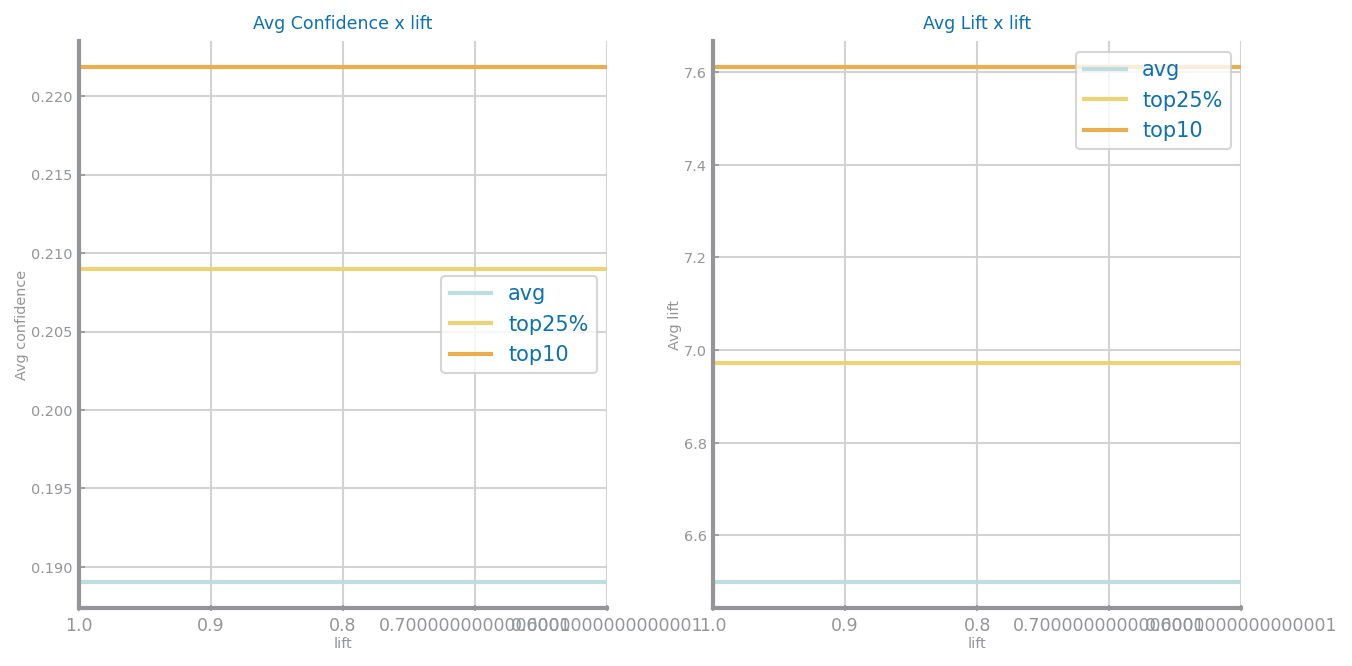

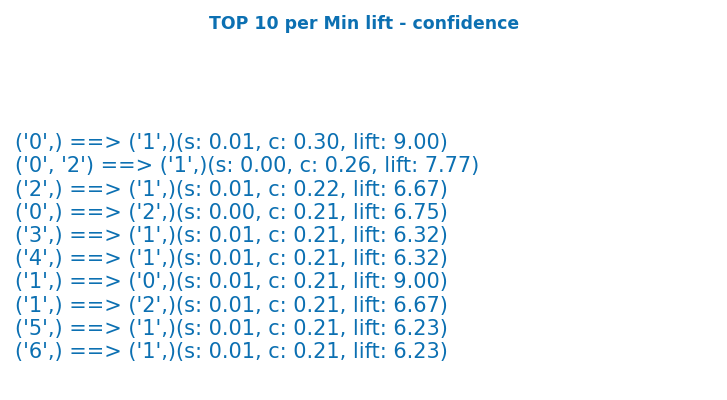

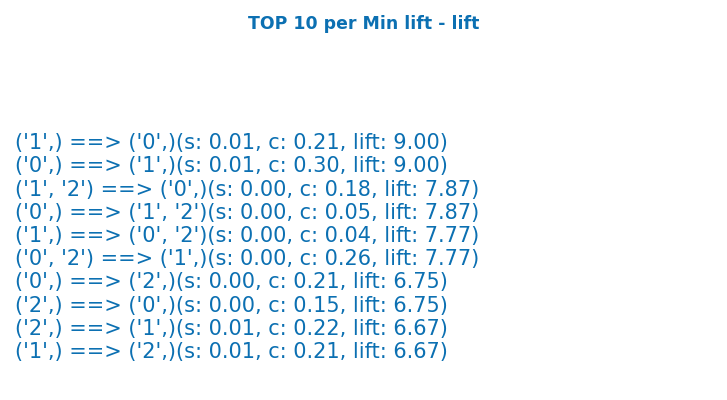

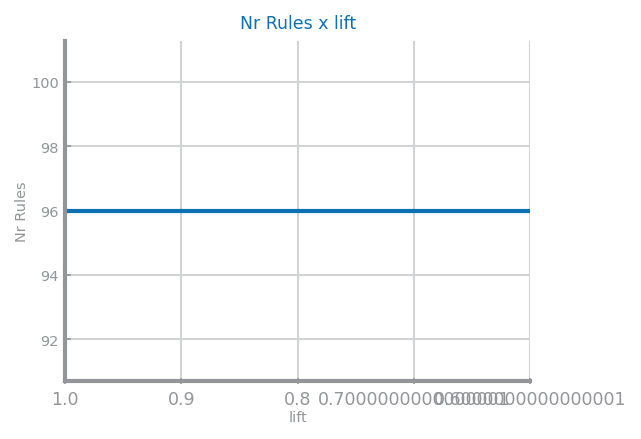

In [141]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'lift', var_min_conf)
ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x lift', xlabel='lift', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Leverage

In [142]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='leverage', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [143]:
#var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
#nr_rules_cf = analyse_per_metric(rules, 'lift', var_min_conf)
#ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x lift', xlabel='lift', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Conviction

In [144]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='conviction', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 96 rules


Analyse per conviction...


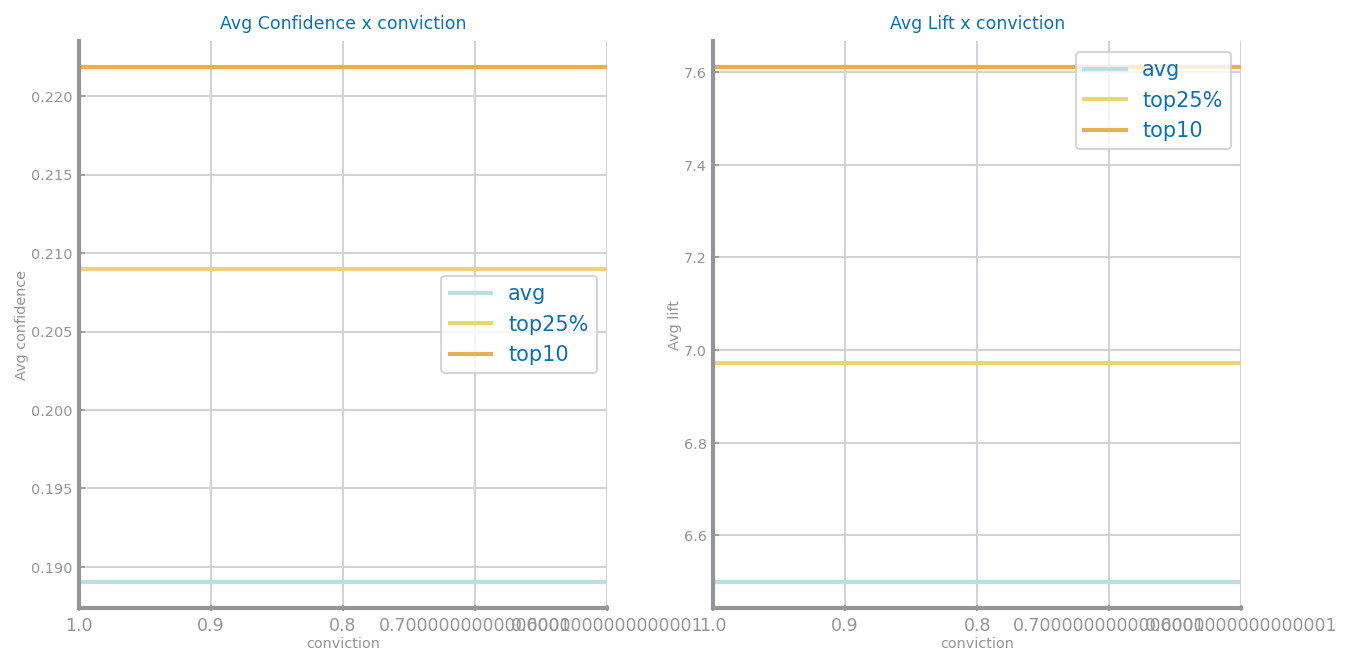

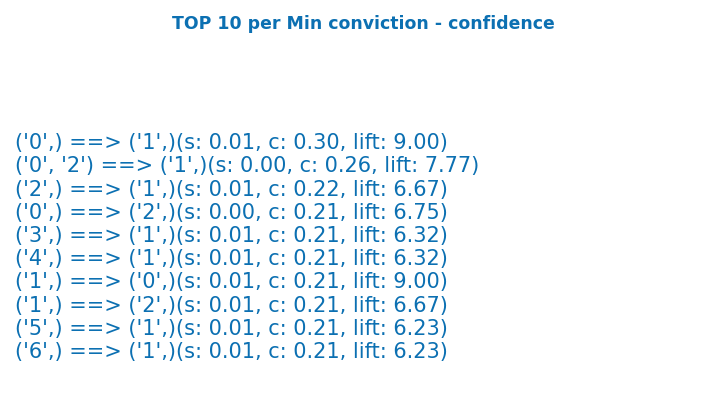

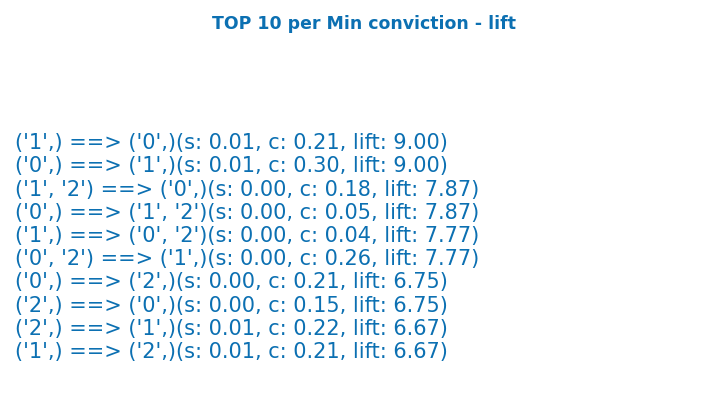

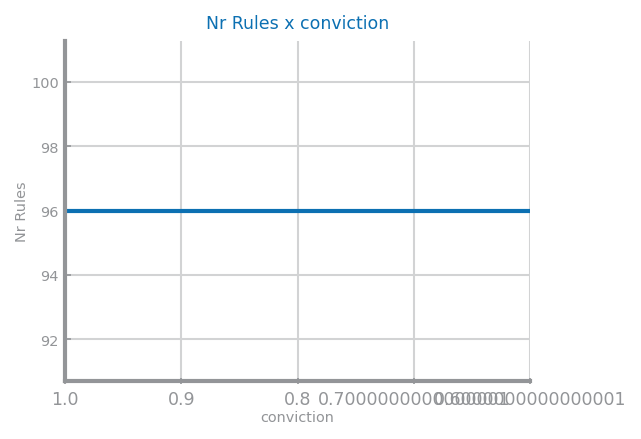

In [145]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'conviction', var_min_conf)
ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x conviction', xlabel='conviction', ylabel='Nr Rules', percentage=False)

<br/>
<br/>
<br/>
<br/>
<br/>

## QSAR Reduced32 Oral Toxicity

### Imports

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
import mlxtend.frequent_patterns as pm
from mlxtend.preprocessing import TransactionEncoder

### Load Data

In [150]:
data: pd.DataFrame = pd.read_csv('../datasets/oral_reduced/ORAL_reduced32.csv', sep=';', header=None)   

data.columns = [str(i) for i in range(0, 33)]

data.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,00000000001000001000000000000000,00000000100000000000000000000000,00000000000000100010000000001000,00000000000000000000000000000000,00000000000000000000000000000000,00000000000000000011100001000000,00100000000000000000000000000010,01000000000000000000000000000000,00000000000100000000000000000000,10000000000000000000000000000000,...,00010000000000000000001100000000,00000000000000000010100000000000,00000000000000000000000000000000,00000000000000000000000000000000,00000001000000000000000000000000,00000000010000000000000000000000,01000000100000000000000000000000,10000000001000001000000001000100,00000000000000000000000000000000,negative
1,00100000001000001000000000000000,00000000000000000000000000000000,00000000000000100000000000001000,00000000000000000000000000000000,00000000000000000000000000000000,00000000000000000010100001001000,00000000000100000000000000000010,00000000000000000000000000000000,00000000000000000000000000000000,10000000000000000000000000000010,...,00000000000000000000001100000000,00000000000000000010100000000000,00000000000000000000000000000000,00000000001000000000000000000000,00000001000000000100000000000000,00000010011000000000000000000000,01000000100000000000000000000000,10010000001000001000000001000000,00010000000000010000000000000000,negative
2,00000000001000001000000000000000,00000000000100000000000000000000,00000000000000100000000000001000,00000000000000000000000000000000,00000000000000000000000000000000,00000000001000000010100001000000,00000000000000000000000000000010,00000000000000000000000000000000,00000000000000000000000000000000,10000000000000000000010001000000,...,00000000000000000000001100000000,00000000000000000000100000000000,00000000000000000000000000000000,00000000000000000000000000000000,00000001000000000000000000101000,00000010010000000000000001000000,01000000100000000000000000000000,10000000001100001000000001000000,00110000000000000000000001000000,negative
3,00000001001000001000000000000000,00000000000000000000000000000000,00000000000000100000000000001010,00000000000000000000000000000000,00010000000000000000000000000000,00000000000000000010100001000000,00000000000000000000000000000010,00000000000000000000000001000000,00000000000000000000000000000000,10000000000000000000000000000000,...,00000000000000000000001100000000,00000000000000000000100000000000,00000000000000000000000000000000,00000000000000000000000000000000,00000001010000000000010000000000,00000010010000000000000000000000,01001000100000000000000000000000,10000000001000001000000001000000,00010000000000001000000000000000,negative
4,00000000000001001000000000000000,00000000100000000000000000010000,00000000000000100000000000001000,00001000000000000000000000000000,00000000000000000000000000010000,00000000000000000000010000000000,00000000000101000000100000000010,00000000000000000000000001000000,00001000000000000000000000000000,10000000010000000000000000001000,...,01000000000000000000001100000000,00000000000000000000000000001010,00000000000001000001000000000000,00000000000000000000000000000000,00000001000000000100000000000000,00000010010000000000000000000000,00000010000000000000000000100000,10000000001000001000000001000000,00010100000000010000000000000000,negative


### Patterns

Processing 2 combinations | Sampling itemset size 2
2 patterns


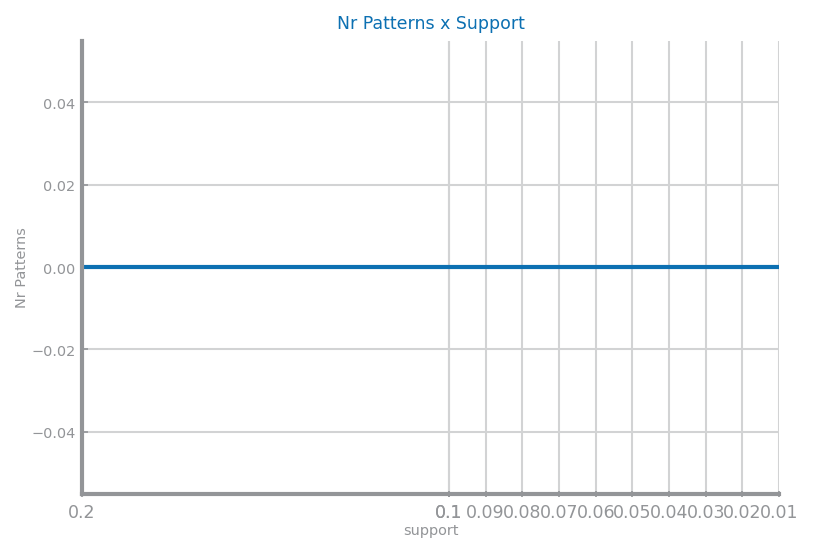

In [151]:
MIN_SUP: float = 0.001
var_min_sup =[0.2, 0.1] + [i*MIN_SUP for i  in range(100, 0, -10)]

te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
data = pd.DataFrame(te_ary, columns=te.columns_)

patterns: pd.DataFrame = pm.apriori(data, min_support=MIN_SUP, use_colnames=True, verbose=True)
print(len(patterns),'patterns')
nr_patterns = []
for sup in var_min_sup:
    pat = patterns[patterns['support']>=sup]
    nr_patterns.append(len(pat))

plt.figure(figsize=(6, 4))
ds.plot_line(var_min_sup, nr_patterns, title='Nr Patterns x Support', xlabel='support', ylabel='Nr Patterns')
plt.show()

### Association Rules

In [152]:
def plot_top_rules(rules: pd.DataFrame, metric: str, per_metric: str) -> None:
    _, ax = plt.subplots(figsize=(6, 3))
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(f'TOP 10 per Min {per_metric} - {metric}', fontweight="bold")
    text = ''
    cols = ['antecedents', 'consequents']
    rules[cols] = rules[cols].applymap(lambda x: tuple(x))
    for i in range(len(rules)):
        rule = rules.iloc[i]
        text += f"{rule['antecedents']} ==> {rule['consequents']}"
        text += f"(s: {rule['support']:.2f}, c: {rule['confidence']:.2f}, lift: {rule['lift']:.2f})\n"
    ax.text(0, 0, text)
    plt.show()

def analyse_per_metric(rules: pd.DataFrame, metric: str, metric_values: list) -> list:
    print(f'Analyse per {metric}...')
    conf = {'avg': [], 'top25%': [], 'top10': []}
    lift = {'avg': [], 'top25%': [], 'top10': []}
    top_conf = []
    top_lift = []
    nr_rules = []
    for m in metric_values:
        rs = rules[rules[metric] >= m]
        nr_rules.append(len(rs))
        conf['avg'].append(rs['confidence'].mean(axis=0))
        lift['avg'].append(rs['lift'].mean(axis=0))

        top_conf = rs.nlargest(int(0.25*len(rs)), 'confidence')
        conf['top25%'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(int(0.25*len(rs)), 'lift')
        lift['top25%'].append(top_lift['lift'].mean(axis=0))

        top_conf = rs.nlargest(10, 'confidence')
        conf['top10'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(10, 'lift')
        lift['top10'].append(top_lift['lift'].mean(axis=0))

    _, axs = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)
    ds.multiple_line_chart(metric_values, conf, ax=axs[0, 0], title=f'Avg Confidence x {metric}',
                           xlabel=metric, ylabel='Avg confidence')
    ds.multiple_line_chart(metric_values, lift, ax=axs[0, 1], title=f'Avg Lift x {metric}',
                           xlabel=metric, ylabel='Avg lift')
    plt.show()

    plot_top_rules(top_conf, 'confidence', metric)
    plot_top_rules(top_lift, 'lift', metric)

    return nr_rules

### Quality Evaluation per Confidence

In [153]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='confidence', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [154]:
#var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
#nr_rules_cf = analyse_per_metric(rules, 'confidence', var_min_conf)
#ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Confidence', xlabel='confidence', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Support

In [155]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='support', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [156]:
#nr_rules_sp = analyse_per_metric(rules, 'support', var_min_sup)
#ds.plot_line(var_min_sup, nr_rules_sp, title='Nr rules x Support', xlabel='support', ylabel='Nr. rules', percentage=False)

### Quality Evaluation per Lift

In [157]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='lift', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [158]:
#var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
#nr_rules_cf = analyse_per_metric(rules, 'lift', var_min_conf)
#ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x lift', xlabel='lift', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Leverage

In [159]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='leverage', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [160]:
#var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
#nr_rules_cf = analyse_per_metric(rules, 'lift', var_min_conf)
#ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x lift', xlabel='lift', ylabel='Nr Rules', percentage=False)

### Quality Evaluation per Conviction

In [161]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='conviction', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 0 rules


In [162]:
#var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
#nr_rules_cf = analyse_per_metric(rules, 'conviction', var_min_conf)
#ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x conviction', xlabel='conviction', ylabel='Nr Rules', percentage=False)